In [54]:
import os
from dotenv import load_dotenv
import requests as r
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
#добавляем датафрейм с регистрациями
url_registrations = "https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01"
response_registrations = r.get(url_registrations)
json_data_registrations = response_registrations.json()
df_regs = pd.DataFrame(json_data_registrations)
df_regs

,datetime,user_id,email,platform,registration_type
0,2023-03-01T07:40:13,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01T13:14:00,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01T03:05:50,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01T00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01T18:31:52,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google
...,...,...,...,...,...
21831,2023-08-31T07:32:08,a94b4a28-f25c-433c-b4ef-85af7d5b0c11,ikelley@example.net,ios,apple
21832,2023-08-31T23:25:50,fc709c6b-528b-40d8-8980-c2c278e5a628,brittanycox@example.net,ios,apple
21833,2023-08-31T19:29:18,11e32805-7571-4108-8e50-e211d051bf7e,aryan@example.net,ios,apple
21834,2023-08-31T19:38:54,bce7b818-768b-434a-b6af-573cd60bff7f,emartinez@example.net,ios,email


In [56]:
#добавляем датафрейм с посещениями
url_visits = "https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01"
response_visits = r.get(url_visits)
json_data_visits = response_visits.json()
df_visits = pd.DataFrame(json_data_visits)
df_visits

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T10:36:22
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01T06:25:00
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01T10:26:13
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01T12:33:06
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01T01:38:35
...,...,...,...,...
263454,6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-08-29T10:43:29
263455,1d91535e-d984-4f76-bbaa-c14c0fd4f2e2,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-08-29T19:29:16
263456,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T12:51:11
263457,f2496721-7126-430d-976e-777a6cdccb4f,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-08-29T21:45:08


## Шаг 3

In [57]:
#обрабатываем регистрации
filtered_regs = df_regs.drop(['email', 'registration_type'], axis=1)
filtered_regs.sort_values(['datetime', 'user_id'], inplace=True)
filtered_regs['datetime'] = pd.to_datetime(filtered_regs['datetime']).dt.date

filtered_regs = filtered_regs.groupby(['datetime', 'platform']).agg('count')
filtered_regs.columns = ['registrations']
filtered_regs

registrations
datetime   platform               
2023-03-01 android              61
           ios                  18
           web                   8
2023-03-02 android              59
           ios                  24
...                            ...
2023-08-30 ios                  40
           web                  34
2023-08-31 android              42
           ios                  36
           web                  46

[552 rows x 1 columns]

In [58]:
#обрабатываем посещения
filtered_visits = df_visits.drop(['user_agent'], axis=1)
filtered_visits = filtered_visits.drop(filtered_visits[filtered_visits['platform'] == 'bot'].index)
filtered_visits.sort_values(['datetime', 'visit_id'], inplace=True)

filtered_visits = filtered_visits.groupby(['visit_id', 'platform']).agg('max')
filtered_visits['datetime'] = pd.to_datetime(filtered_visits['datetime']).dt.date
filtered_visits = filtered_visits.reset_index()

filtered_visits = filtered_visits.groupby(['datetime', 'platform']).agg('count')
filtered_visits.columns = ['visits']
filtered_visits

visits
datetime   platform        
2023-03-01 android       75
           ios           22
           web          279
2023-03-02 android       67
           ios           31
...                     ...
2023-08-30 ios           66
           web         1227
2023-08-31 android       57
           ios           50
           web          721

[552 rows x 1 columns]

In [90]:
#объединяем датафреймы и считаем конверсию
conv_df = filtered_visits.join(
    filtered_regs,
    how='outer'
)
conv_df = conv_df.fillna(0)
conv_df['visits'] = conv_df['visits'].astype('int')
conv_df['registrations'] = conv_df['registrations'].astype('int')

conv_df['conversion'] = conv_df['registrations'] / conv_df['visits'] * 100
conv_df.replace([np.inf, -np.inf], 0, inplace=True)
conv_df = conv_df.reset_index()
conv_df

,datetime,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [91]:
conv_df.to_json('conversion.json')

## Шаг 4

In [61]:
#добавляем датафрейм с рекламой
ads = pd.read_csv('ads.csv')
ads

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265
...,...,...,...,...,...
154,2023-09-13T05:34:02,vk,social,intro_to_python_course,277
155,2023-09-14T18:25:13,vk,social,intro_to_python_course,221
156,2023-09-15T15:35:47,vk,social,intro_to_python_course,175
157,2023-09-16T05:30:26,vk,social,intro_to_python_course,224


In [62]:
#обрабатываем датафрейм с рекламой
filtered_ads = ads.drop(['utm_source', 'utm_medium'], axis=1)
filtered_ads.sort_values(['date'], inplace=True)
filtered_ads['date'] = pd.to_datetime(filtered_ads['date']).dt.date
filtered_ads.columns = ['datetime', 'utm_campaign', 'cost']
filtered_ads

,datetime,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265
...,...,...,...
154,2023-09-13,intro_to_python_course,277
155,2023-09-14,intro_to_python_course,221
156,2023-09-15,intro_to_python_course,175
157,2023-09-16,intro_to_python_course,224


In [63]:
#создаем датафрейм без конверсии и аггрегации по платформам
vis_and_reg = conv_df.drop(['conversion'], axis=1)
vis_and_reg = vis_and_reg.groupby(['datetime']).agg(visits=('visits', 'sum'), registrations=('registrations', 'sum'))
vis_and_reg = vis_and_reg.reset_index()
vis_and_reg

,datetime,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,106
2,2023-03-03,683,107
3,2023-03-04,647,159
4,2023-03-05,707,115
...,...,...,...
179,2023-08-27,795,88
180,2023-08-28,635,83
181,2023-08-29,1268,143
182,2023-08-30,1328,101


In [64]:
#объединяем данные о посещениях, регистрациях и рекламе
ads_df = pd.merge(
    vis_and_reg,
    filtered_ads,
    left_on='datetime',
    right_on='datetime',
    how='left'
)
ads_df['cost'] = ads_df['cost'].fillna(0)
ads_df

,datetime,visits,registrations,utm_campaign,cost
0,2023-03-01,376,87,advanced_algorithms_series,212.0
1,2023-03-02,613,106,advanced_algorithms_series,252.0
2,2023-03-03,683,107,advanced_algorithms_series,202.0
3,2023-03-04,647,159,advanced_algorithms_series,223.0
4,2023-03-05,707,115,advanced_algorithms_series,265.0
...,...,...,...,...,...
179,2023-08-27,795,88,intro_to_python_course,222.0
180,2023-08-28,635,83,intro_to_python_course,223.0
181,2023-08-29,1268,143,intro_to_python_course,190.0
182,2023-08-30,1328,101,intro_to_python_course,109.0


In [65]:
ads_df.to_json('ads.json')

## Шаг 5

In [85]:
#создаем папку для графиков
current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')
if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

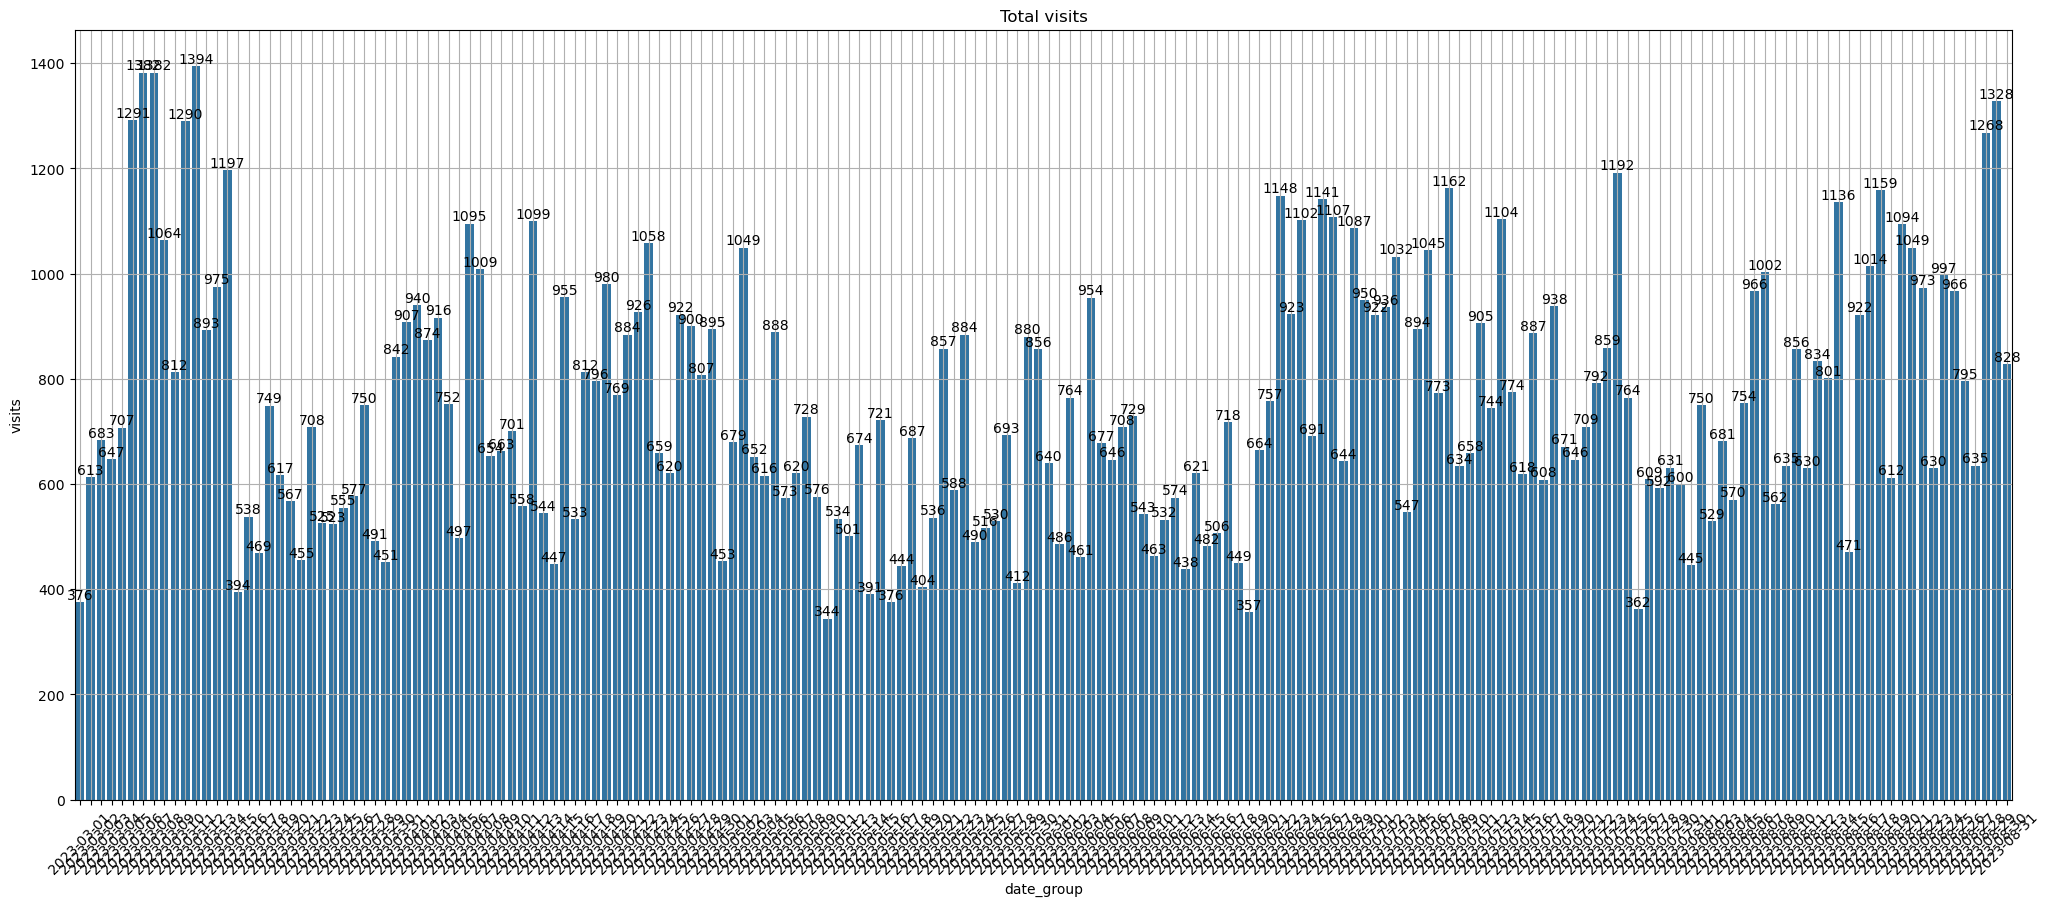

In [66]:
#1
plt.figure(figsize = (25, 10))
ax = sns.barplot(
    x='datetime',
    y='visits',
    data=ads_df
)
ax.bar_label(ax.containers[0])
plt.title('Total visits')
plt.xlabel('date_group')
plt.xticks(rotation=45)
plt.grid()
plt.show

fig_total_visits = ax.get_figure()
fig_total_visits.savefig('./charts/visits_by_date.png')

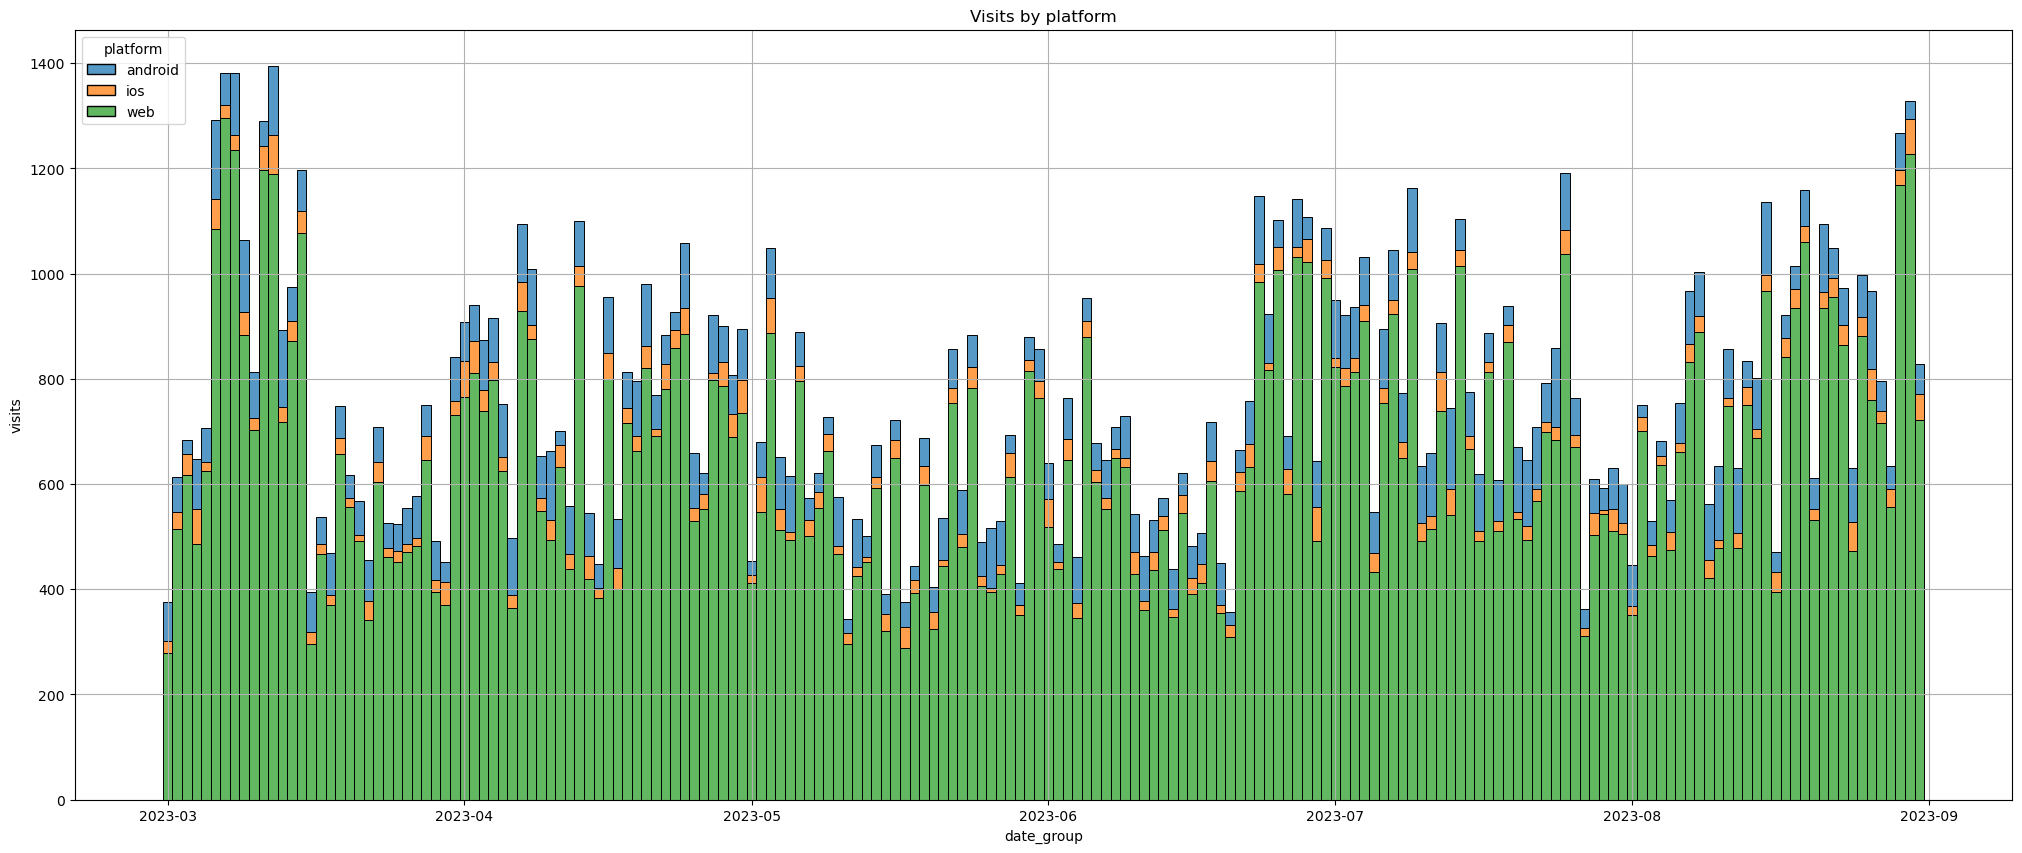

<Figure size 640x480 with 0 Axes>

In [67]:
#2

plt.figure(figsize=(25, 10))

ax = sns.histplot(
    x='datetime',
    weights='visits',
    hue='platform',
    data=conv_df,
    multiple='stack'
)

plt.title('Visits by platform')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.grid(True)
plt.show()

plt.savefig('charts/visits_by_platform')

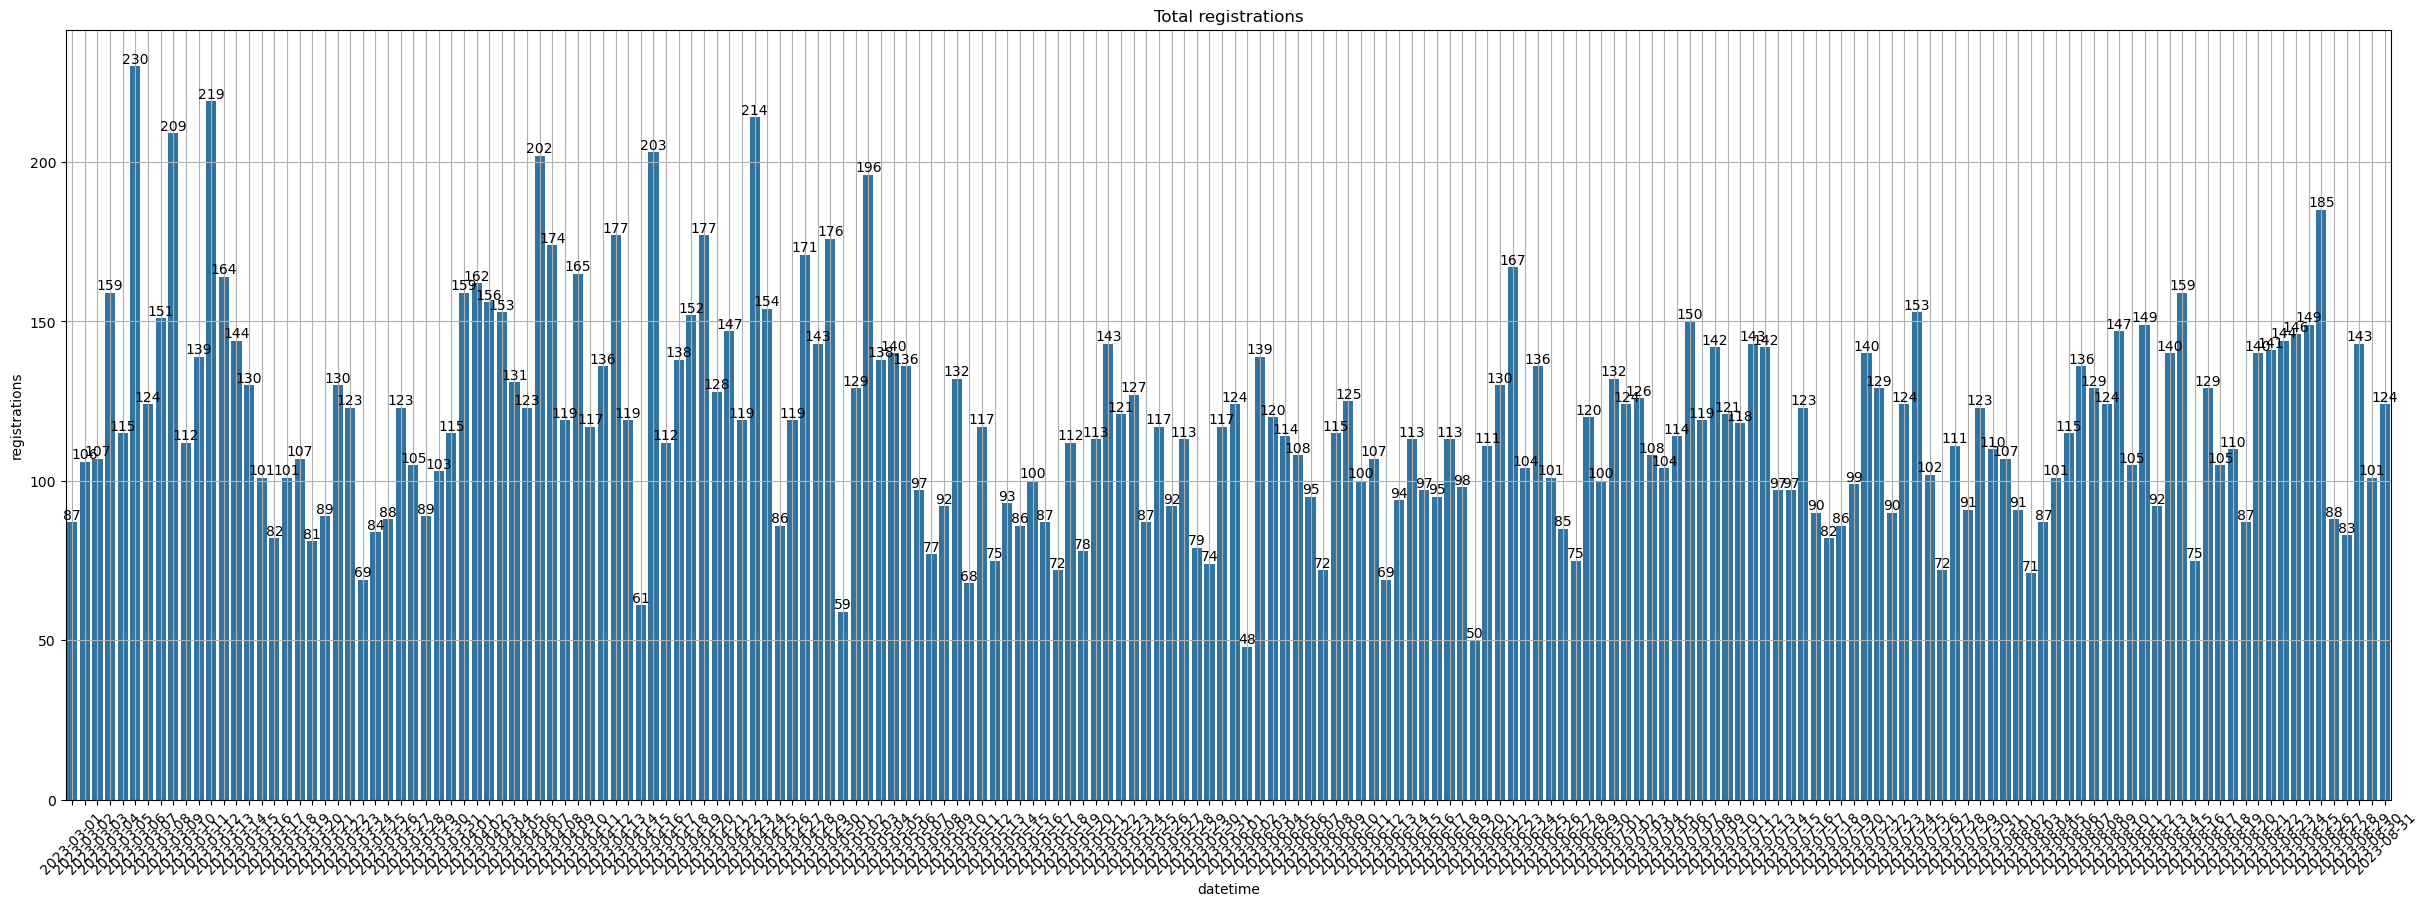

In [70]:
#3

plt.figure(figsize = (30, 10))

ax = sns.barplot(
    x = 'datetime',
    y = 'registrations',
    data=ads_df
)

ax.bar_label(ax.containers[0])
plt.title('Total registrations')
plt.xticks(rotation=45)
plt.grid()
plt.show

plt.savefig('charts/total_registrations')

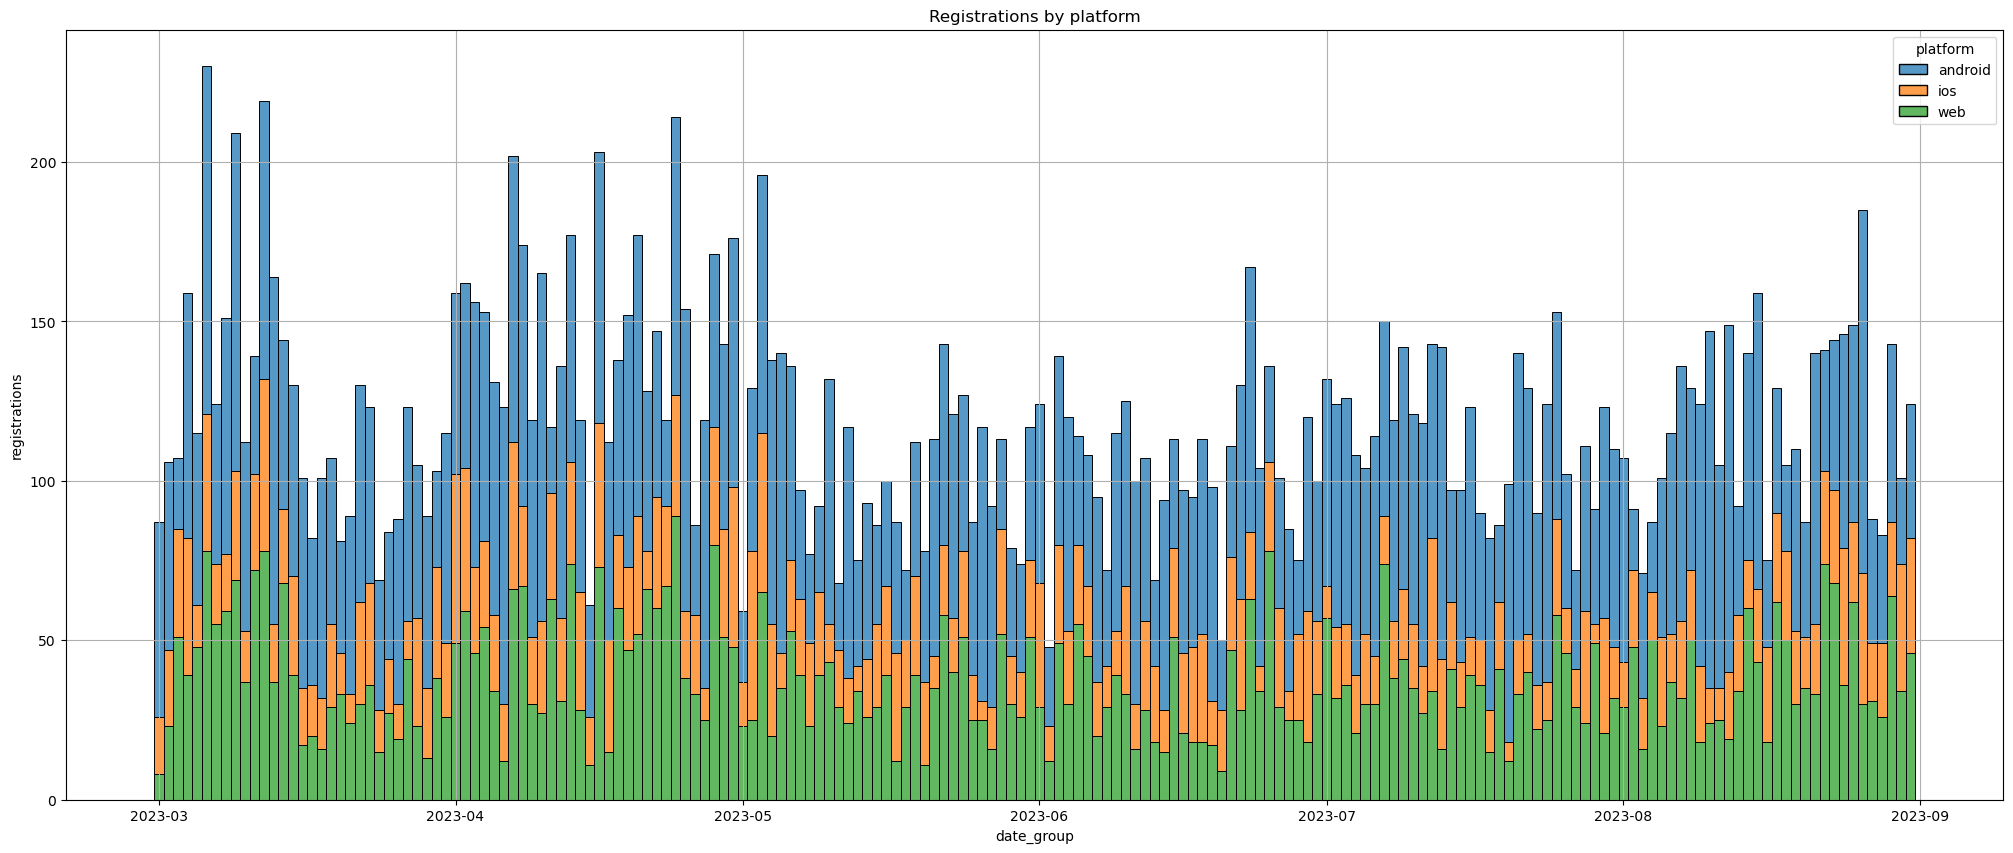

<Figure size 640x480 with 0 Axes>

In [72]:
#4

fig, ax = plt.subplots(figsize=(25, 10))

ax = sns.histplot(
    x='datetime',
    weights='registrations',
    hue='platform',
    data=conv_df,
    multiple='stack'
)


plt.title('Registrations by platform')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.grid(True)
plt.show()

plt.savefig('charts/registrations_by_platform')

In [73]:
#создаем датафрейм с общей конверсией
overall_conv = conv_df.drop(['platform', 'conversion'], axis=1)
overall_conv = overall_conv.groupby('datetime').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum'))
overall_conv['conversion'] = round (overall_conv['registrations'] / overall_conv['visits'] * 100, 2)
overall_conv = overall_conv.drop(['visits', 'registrations'], axis=1)
overall_conv = overall_conv.reset_index()
overall_conv.columns = ['date_group', 'conversion']
overall_conv

,date_group,conversion
0,2023-03-01,23.14
1,2023-03-02,17.29
2,2023-03-03,15.67
3,2023-03-04,24.57
4,2023-03-05,16.27
...,...,...
179,2023-08-27,11.07
180,2023-08-28,13.07
181,2023-08-29,11.28
182,2023-08-30,7.61


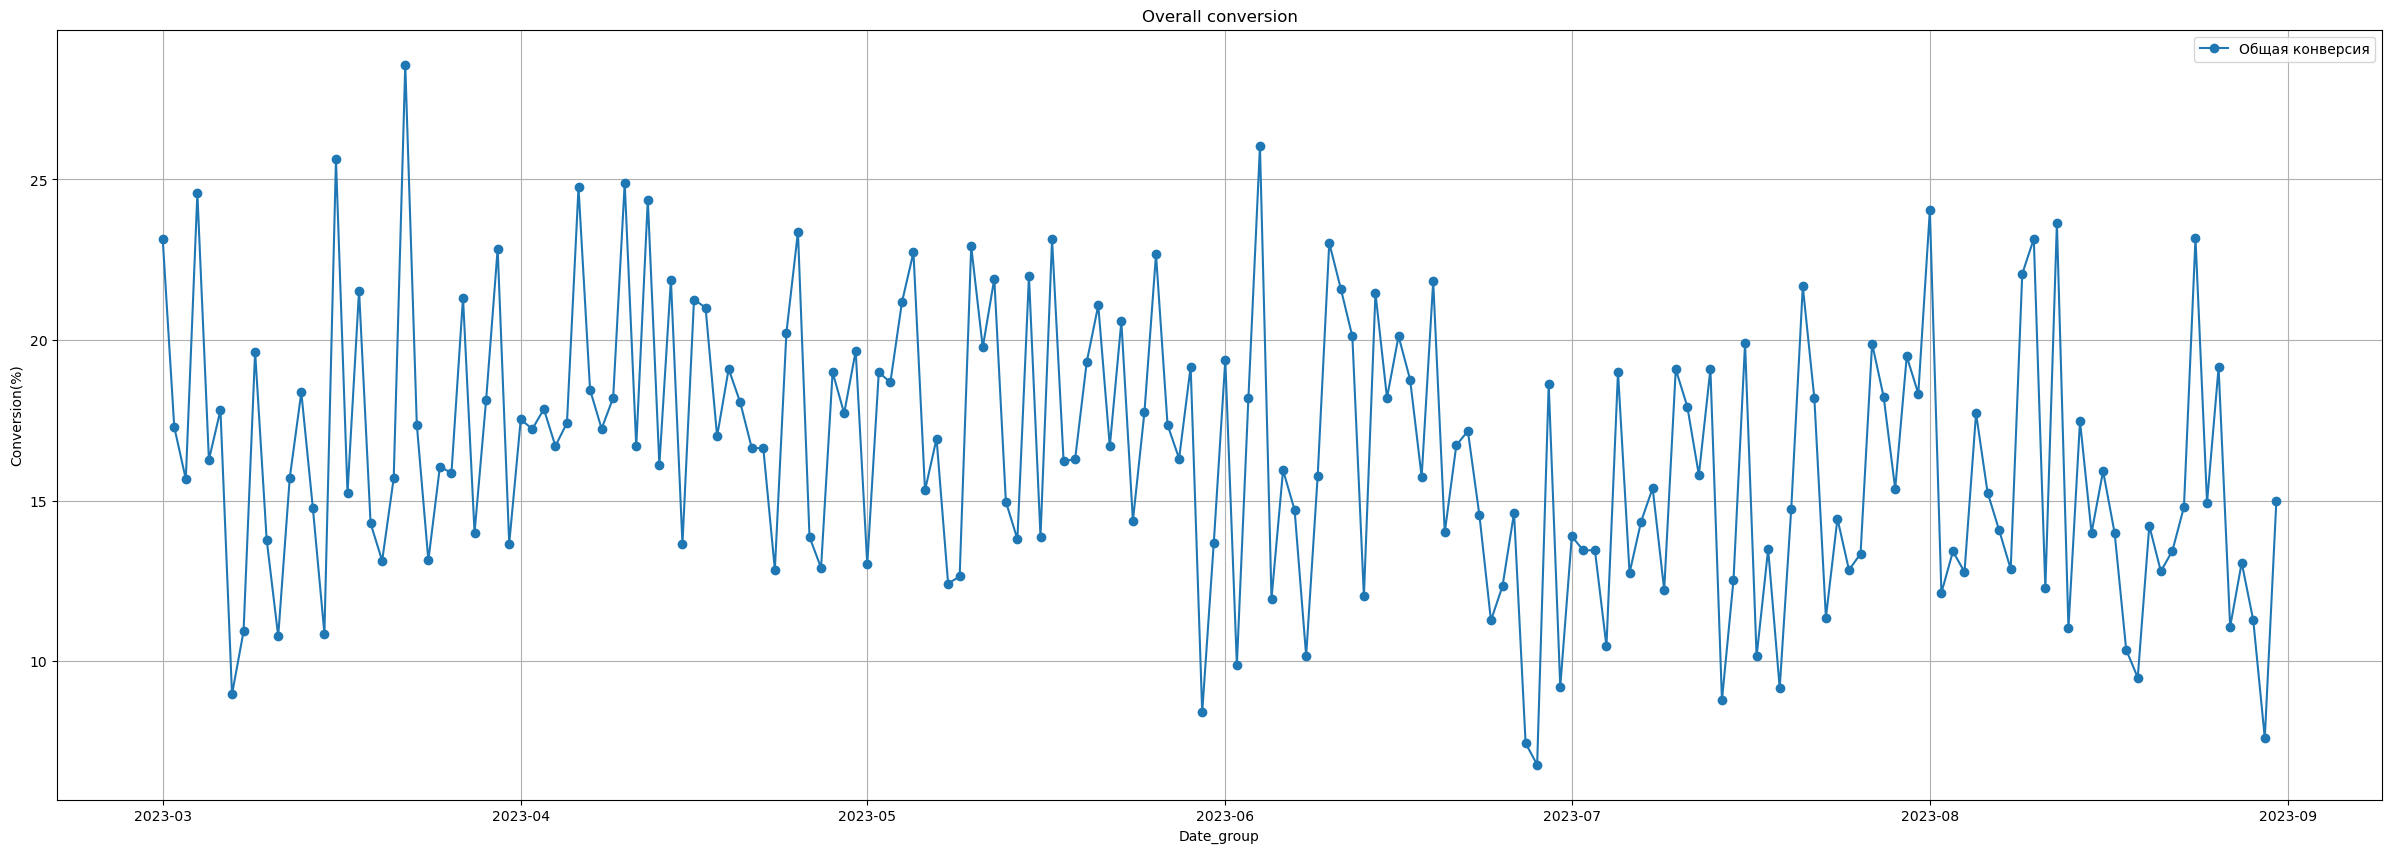

<Figure size 640x480 with 0 Axes>

In [74]:
#5

plt.figure(figsize=(30, 10))

plt.plot(
    'date_group',
    'conversion',
    data=overall_conv,
    marker='o',
    label='Общая конверсия'
)

plt.legend()
plt.title('Overall conversion')
plt.xlabel('Date_group')
plt.ylabel('Conversion(%)')
plt.grid(True)

plt.show()

plt.savefig('charts/overall_conversion')

In [75]:
#создаем список платформ
platforms = conv_df['platform'].unique()
platforms

array(['android', 'ios', 'web'], dtype=object)

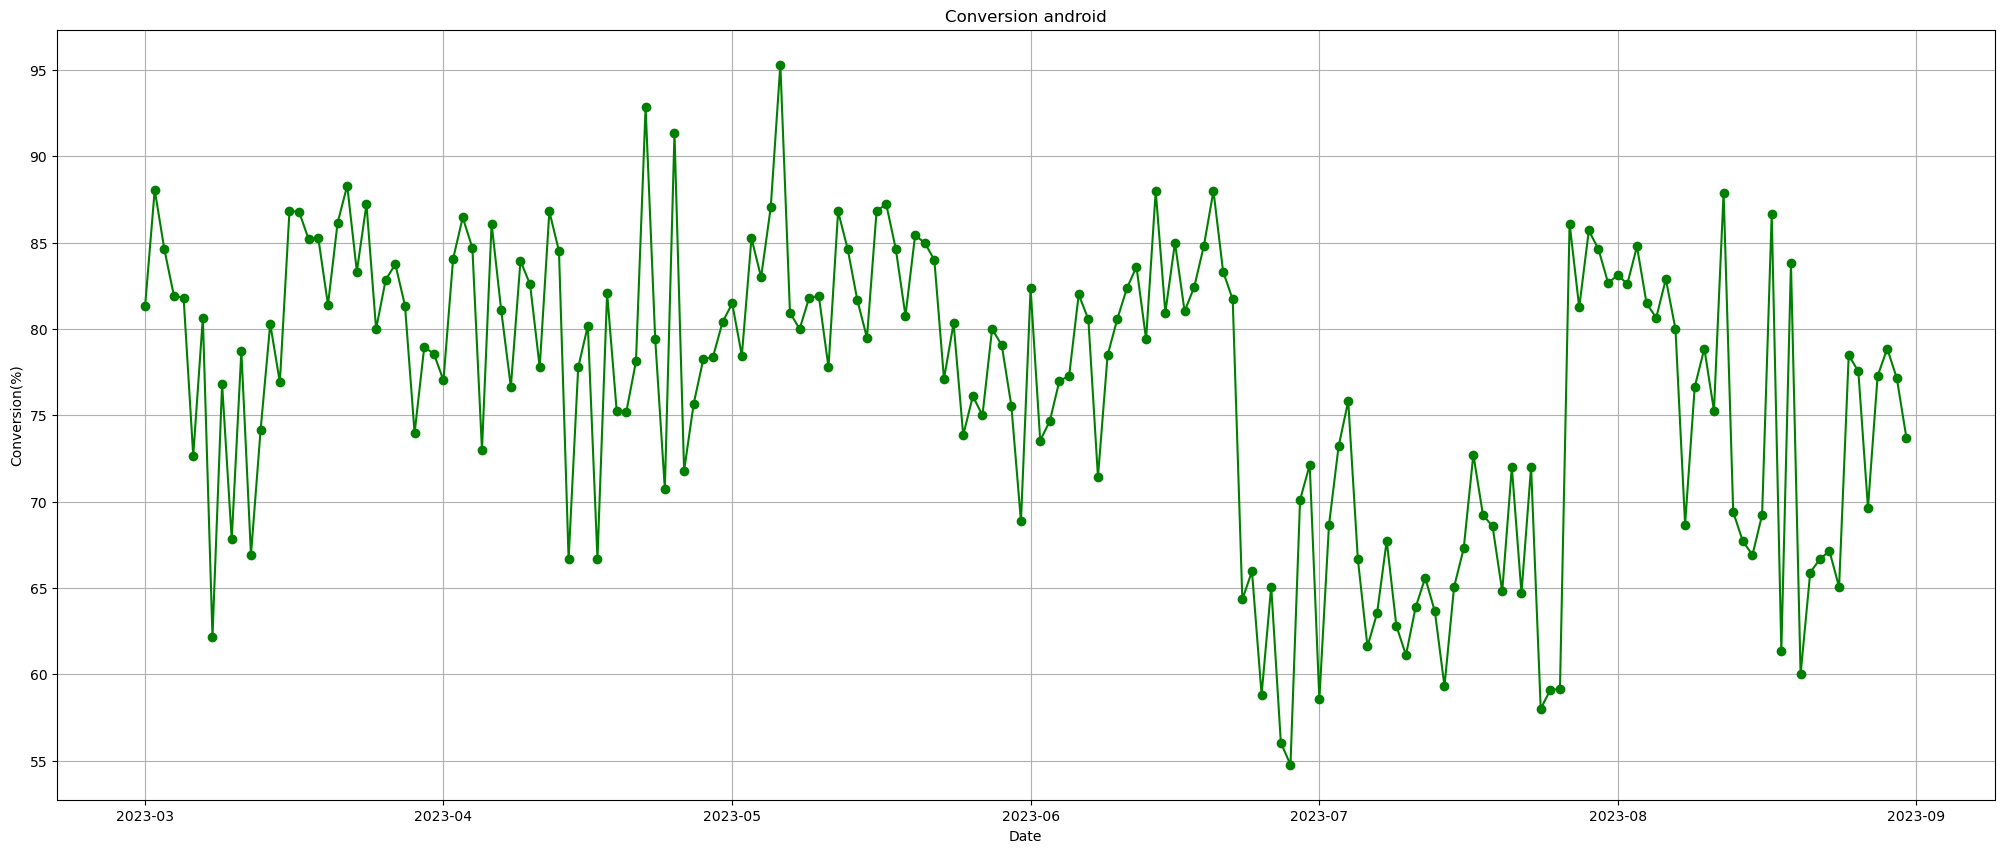

<Figure size 640x480 with 0 Axes>

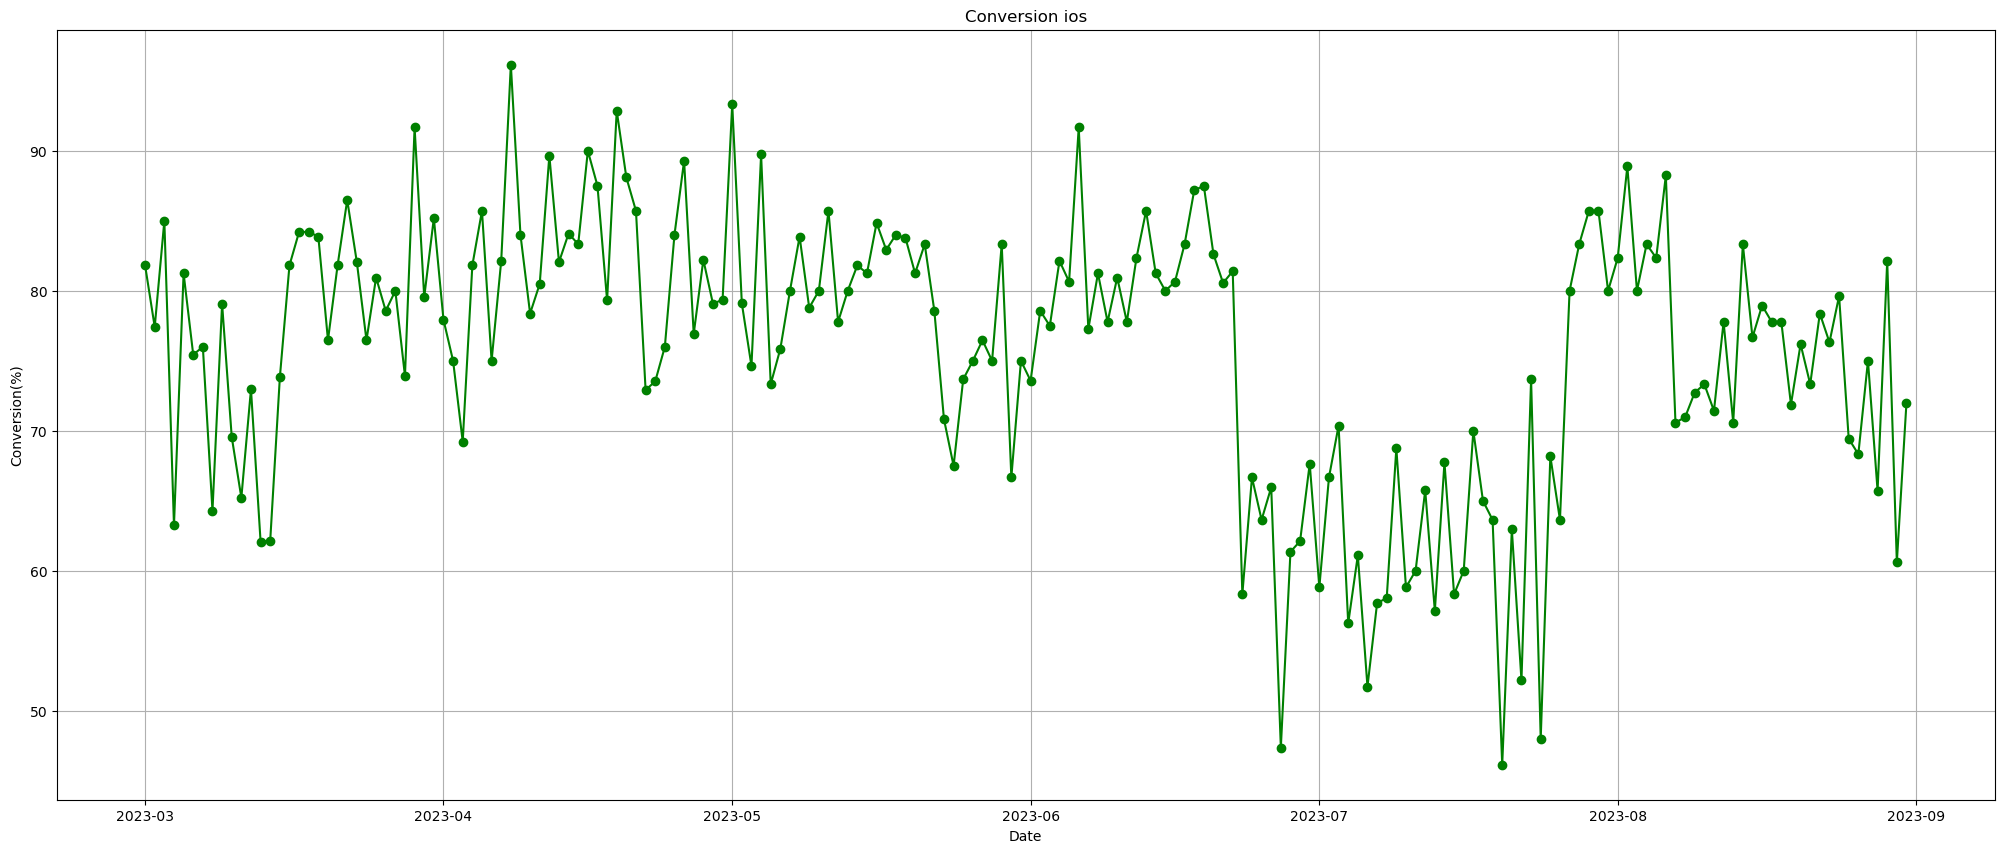

<Figure size 640x480 with 0 Axes>

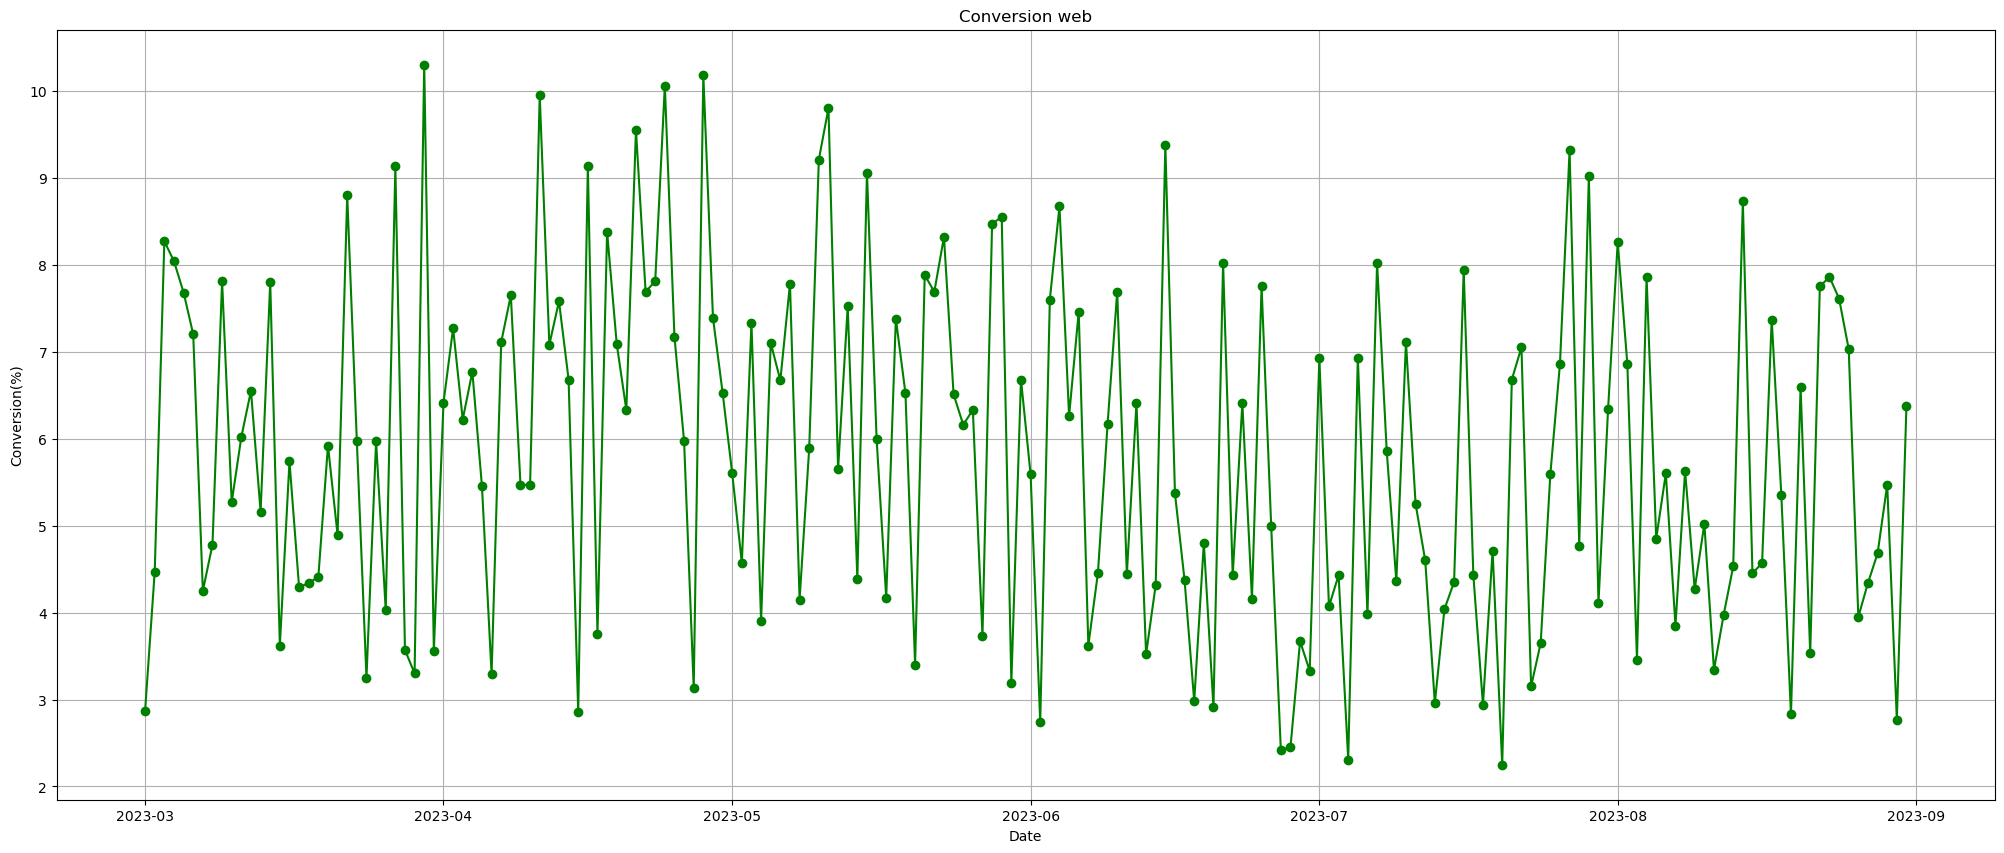

<Figure size 640x480 with 0 Axes>

In [76]:
#6, 7, 8

for p in platforms:
    platform_conv = conv_df[conv_df['platform'] == p].drop(['platform', 'visits', 'registrations'], axis=1)
    plt.figure(figsize=(25, 10))

    plt.plot(
        'datetime',
        'conversion',
        data=platform_conv,
        color='green',
        marker='o'
    )

    plt.title(f'Conversion {p}')
    plt.xlabel('Date')
    plt.ylabel('Conversion(%)')
    plt.grid()
    plt.show()

    plt.savefig(f'charts/{p}_conversion')

In [83]:
#уберем лишние данные для графика
ads_by_day = ads_df.drop(['visits', 'registrations', 'utm_campaign'], axis=1)
#ads_by_day = ads_by_day[ads_by_day['cost'] > 0]
ads_by_day

,datetime,cost
0,2023-03-01,212.0
1,2023-03-02,252.0
2,2023-03-03,202.0
3,2023-03-04,223.0
4,2023-03-05,265.0
...,...,...
179,2023-08-27,222.0
180,2023-08-28,223.0
181,2023-08-29,190.0
182,2023-08-30,109.0


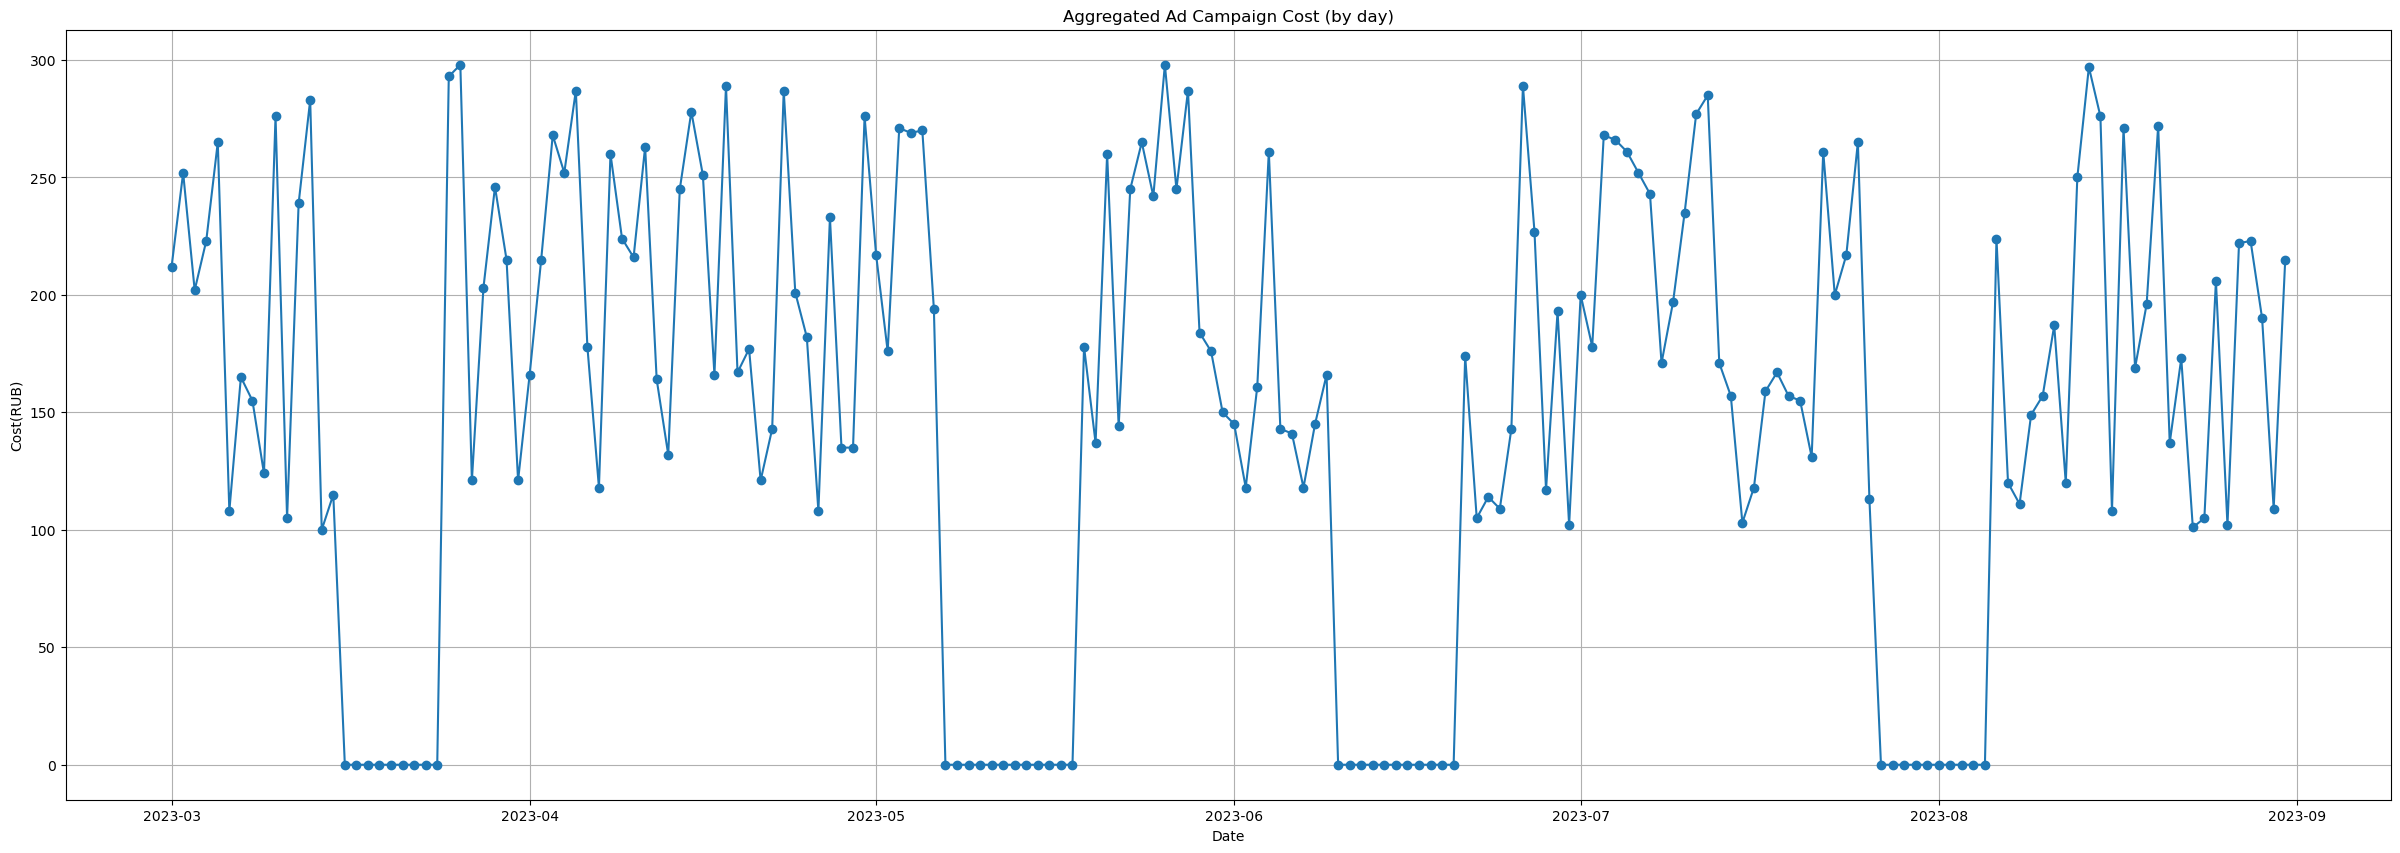

In [84]:
#9

plt.figure(figsize = (30, 10))

plt.plot(
    'datetime',
    'cost',
    data=ads_by_day,
    marker='o'
)

plt.title('Aggregated Ad Campaign Cost (by day)')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.grid(True)
plt.show

plt.savefig('charts/ads_cost')

In [79]:
campaign_periods = ads_df.groupby(['utm_campaign']).agg(start = ('datetime', 'min'), end = ('datetime', 'max')).reset_index()
campaign_periods

,utm_campaign,start,end
0,advanced_algorithms_series,2023-03-01,2023-03-15
1,intro_to_python_course,2023-08-06,2023-08-31
2,ui_ux_design_drive,2023-05-19,2023-06-09
3,virtual_reality_workshop,2023-03-25,2023-05-06
4,women_in_tech_symposium,2023-06-21,2023-07-26


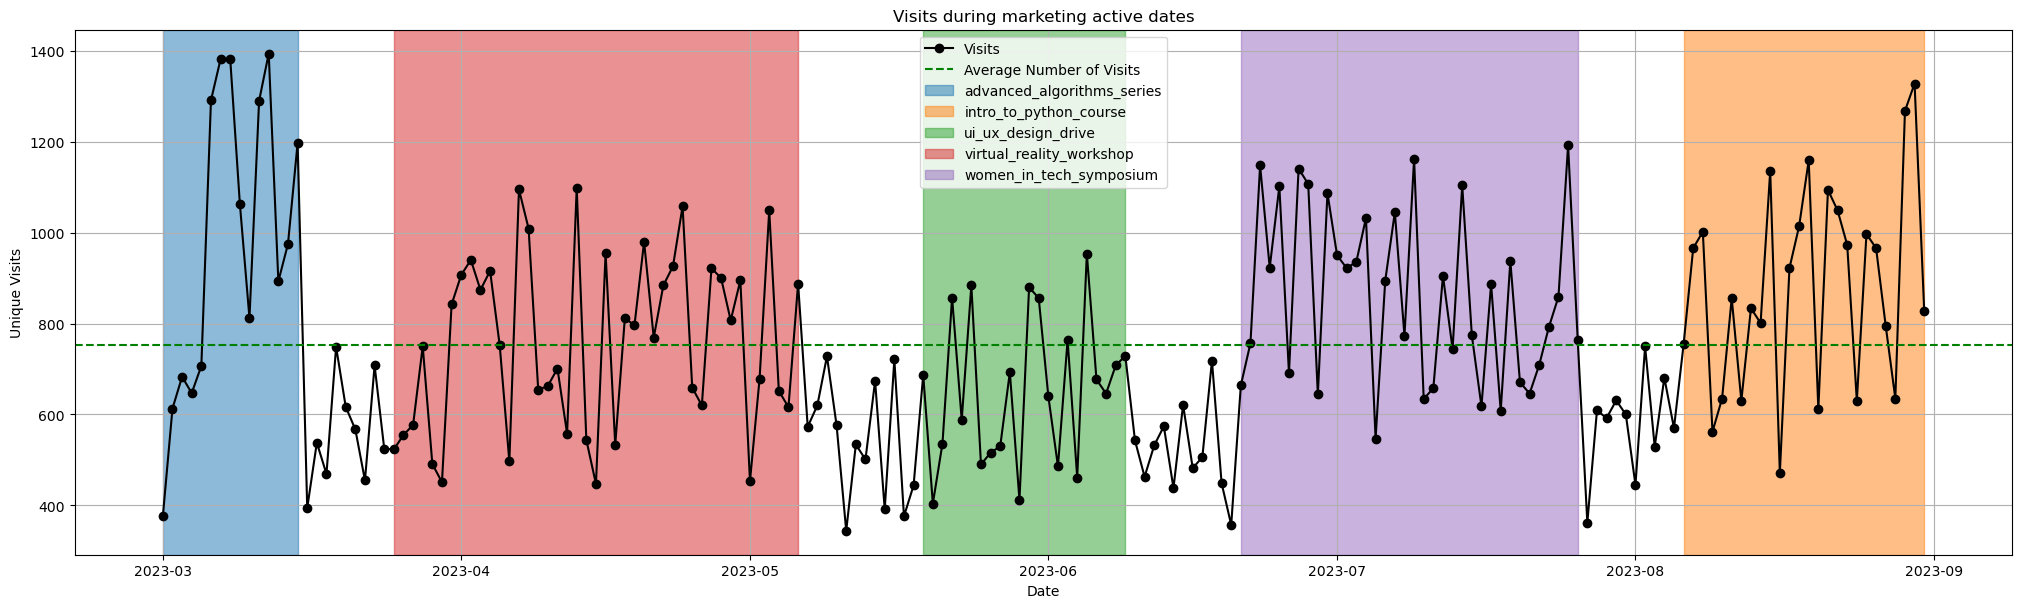

<Figure size 640x480 with 0 Axes>

In [82]:
#10

plt.figure(figsize = (25, 15))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(ads_df['datetime'], ads_df['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(ads_df.visits), linestyle='dashed', color='green', label='Average Number of Visits')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Visits during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.grid(True)

plt.show()

plt.savefig('charts/ads_visits')

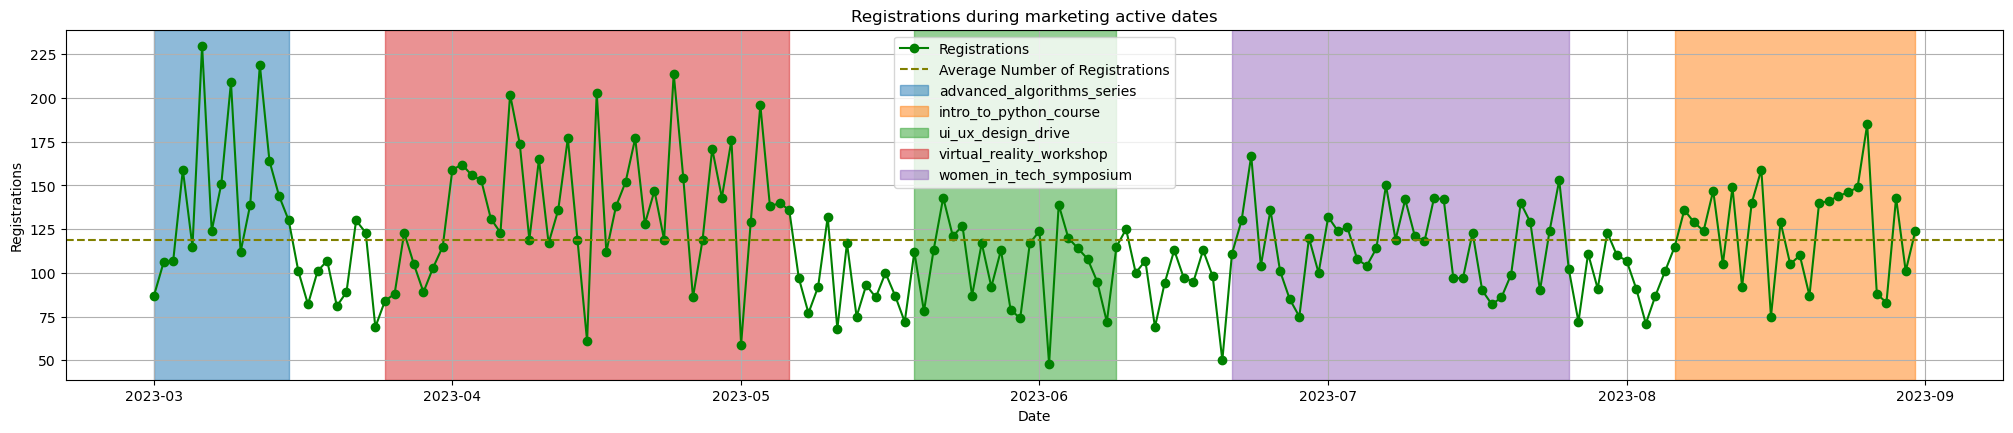

<Figure size 640x480 with 0 Axes>

In [81]:
#11

plt.figure(figsize=(25,10))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(ads_df['datetime'], ads_df['registrations'], marker='o', color='green', label='Registrations')
plt.axhline(y=np.nanmean(ads_df.registrations), linestyle='dashed', color='olive', label='Average Number of Registrations')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Registrations during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.grid(True)

plt.show()

plt.savefig('charts/ads_registrations')